## Explorar o Azure Synapse Analytics

# Provisionar um espaço de trabalho do Azure Synapse Analytics

No painel do PowerShell, insira comandos para clonar este repositório:

In [ ]:
 rm -r dp-203 -f
 git clone https://github.com/MicrosoftLearning/dp-203-azure-data-engineer dp-203

Após a clonagem do repositório, insira os seguintes comandos para mudar para a pasta e execute o script setup.ps1 que ele contém

In [ ]:
 cd dp-203/Allfiles/labs/01
 ./setup.ps1

# Explore o Synapse Studio

No portal do Azure, acesse o grupo de recursos dp203-xxxxxxx

Esse grupo de recursos contém seu espaço de trabalho do Synapse, uma conta de armazenamento para seu data lake, um pool do Apache Spark e um pool de SQL dedicado.

abra o Synapse Studio em uma nova aba do navegador.
https://web.azuresynapse.net/en/workspaces

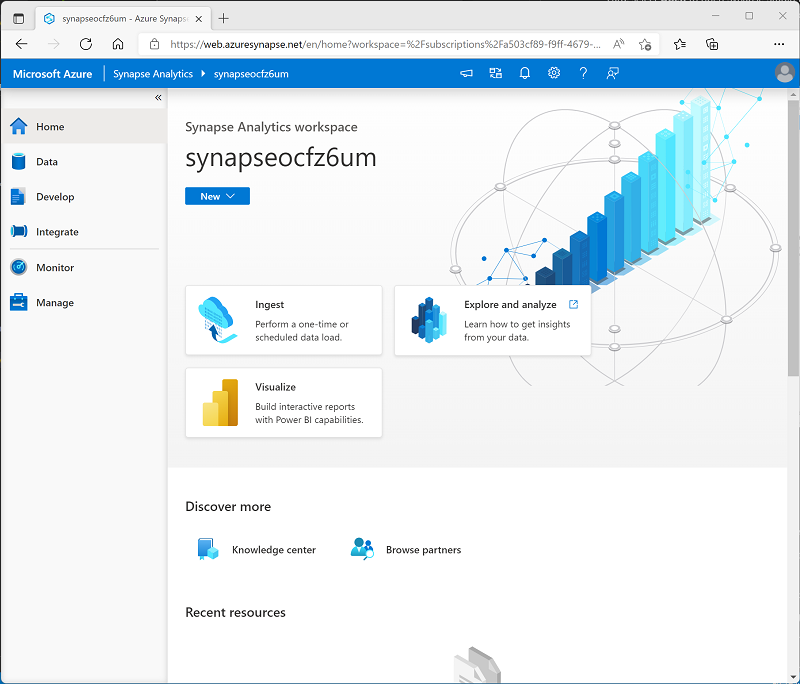

# Ingerir dados com um pipeline

Uma das principais tarefas que você pode executar com o Azure Synapse Analytics é definir pipelines que transferem (e, se necessário, transformam) dados de uma ampla variedade de fontes para seu espaço de trabalho para análise.

No Synapse Studio, na página inicial, selecione Ingerir para abrir a ferramenta Copiar dados(Copy Data
)

Na etapa Sourch, na subetapa Dataset, selecione as seguintes configurações:

In [ ]:
Source type: All
Connection: Create a new connection, and in the Linked service pane that appears, on the Generic protocol tab, select HTTP. Then continue and create a connection to a data file using the following settings:
Name: Products
Description: Product list via HTTP
Connect via integration runtime: AutoResolveIntegrationRuntime
Base URL: https://raw.githubusercontent.com/MicrosoftLearning/dp-203-azure-data-engineer/master/Allfiles/labs/01/adventureworks/products.csv
Server Certificate Validation: Enable
Authentication type: Anonymous

In [ ]:
Relative URL: Leave blank
Request method: GET
Additional headers: Leave blank
Binary copy: Unselected
Request timeout: Leave blank
Max concurrent connections: Leave blank

In [ ]:
File format: DelimitedText
Column delimiter: Comma (,)
Row delimiter: Line feed (\n)
First row as header: Selected
Compression type: None

In [ ]:
Folder path: files/product_data
File name: products.csv
Copy behavior: None
Max concurrent connections: Leave blank
Block size (MB): Leave blank

In [ ]:
File format: DelimitedText
Column delimiter: Comma (,)
Row delimiter: Line feed (\n)
Add header to file: Selected
Compression type: None
Max rows per file: Leave blank
File name prefix: Leave blank

In [ ]:
Task name: Copy products
Task description Copy products data
Fault tolerance: Leave blank
Enable logging: Unselected
Enable staging: Unselected

No Synapse Studio, selecione a página Monitor e, na guia Execuções do pipeline, aguarde a conclusão do pipeline Copiar produtos com o status Bem-sucedido

Visualize a página Integrar e verifique se ela agora contém um pipeline chamado Copiar produtos.

# Visualizar os dados ingeridos

Na página Dados, selecione a aba Vinculado e expanda a hierarquia de contêineres do datalake synapsexxxxxxx (Primário) até ver o armazenamento de arquivos para o seu espaço de trabalho Synapse. Em seguida, selecione o armazenamento de arquivos para verificar se há uma pasta chamada product_data.

contendo um arquivo chamado products.csv foi copiado para este local

Clique com o botão direito do mouse no arquivo de dados products.csv e selecione Visualizar para visualizar os dados ingeridos.

# Use um pool de SQL sem servidor para analisar dados

Usar o Synapse Analytics para consultá-los e analisá-los. Uma das maneiras mais comuns de consultar dados é usar SQL, e no Synapse Analytics você pode usar um pool de SQL sem servidor para executar código SQL em dados em um data lake.

No Synapse Studio, clique com o botão direito do mouse no arquivo products.csv no armazenamento de arquivos do seu espaço de trabalho Synapse, aponte para Novo script SQL e selecione Selecionar as 100 principais linhas.

In [ ]:
 SELECT
     TOP 100 *
 FROM
     OPENROWSET(
         BULK 'https://datalakexxxxxxx.dfs.core.windows.net/files/product_data/products.csv',
         FORMAT = 'CSV',
         PARSER_VERSION='2.0'
     ) AS [result]

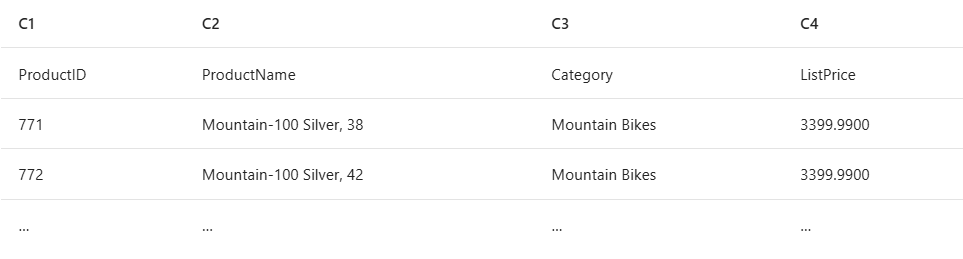

No painel Resultados, selecione a visualização Gráfico e, em seguida, selecione as seguintes configurações para o gráfico:

In [ ]:
 SELECT
     Category, COUNT(*) AS ProductCount
 FROM
     OPENROWSET(
         BULK 'https://datalakexxxxxxx.dfs.core.windows.net/files/product_data/products.csv',
         FORMAT = 'CSV',
         PARSER_VERSION='2.0',
         HEADER_ROW = TRUE
     ) AS [result]
 GROUP BY Category;

In [ ]:
Chart type: Column
Category column: Category
Legend (series) columns: ProductCount
Legend position: bottom - center
Legend (series) label: Leave blank
Legend (series) minimum value: Leave blank
Legend (series) maximum: Leave blank
Category label: Leave blank

O gráfico resultante:

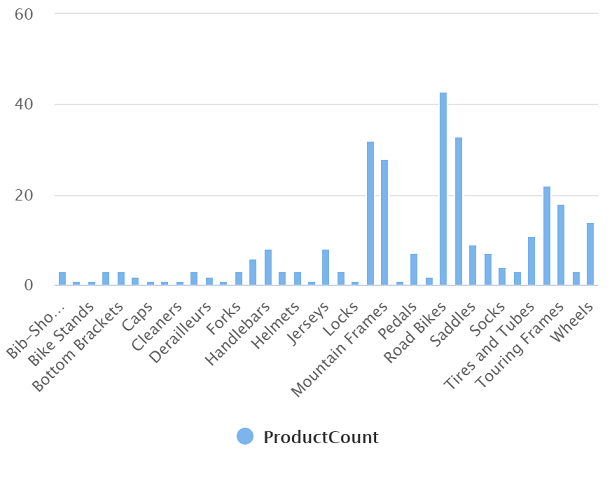

# Use um pool Spark para analisar dados

No Azure Synapse Analytics, você pode executar código Python (e outros) em um pool Spark, que usa um mecanismo de processamento de dados distribuído baseado no Apache Spark.

No Synapse Studio, se a aba de arquivos que você abriu anteriormente contendo o arquivo products.csv não estiver mais aberta, na página Dados, navegue pela pasta product_data. Em seguida, clique com o botão direito do mouse em products.csv, aponte para Novo notebook e selecione Carregar no DataFrame.

No painel Notebook 1 que é aberto, na lista Anexar a, selecione o pool Spark sparkxxxxxxx e certifique-se de que o Idioma esteja definido como PySpark (Python).

In [1]:
 %%pyspark
 df = spark.read.load('abfss://files@datalakexxxxxxx.dfs.core.windows.net/product_data/products.csv', format='csv'
 ## If header exists uncomment line below
 , header=True
 )
 display(df.limit(10))

UsageError: Cell magic `%%pyspark` not found.


os resultados devem aparecer abaixo da célula:

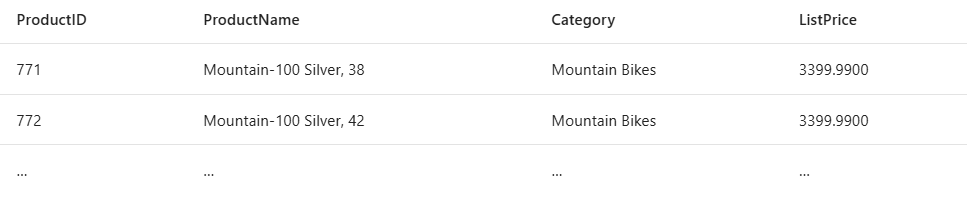

Nos resultados, use o ícone ＋ Código para adicionar uma nova célula de código ao notebook.

Na nova célula de código vazia, adicione o seguinte código:

In [ ]:
 df_counts = df.groupby(df.Category).count()
 display(df_counts)

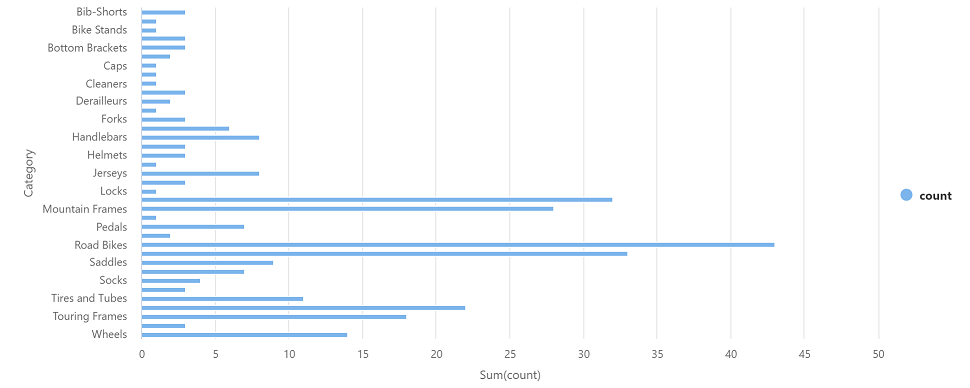

# Use um pool SQL dedicado para consultar um data warehouse

Em muitos casos, uma solução de análise empresarial usa um data lake para armazenar e preparar dados não estruturados que podem ser carregados em um data warehouse relacional para dar suporte a cargas de trabalho de business intelligence (BI). No Azure Synapse Analytics, esses data warehouses podem ser implementados em um pool SQL dedicado.

No Synapse Studio, na página Gerenciar, na seção Pools de SQL, selecione a linha do pool de SQL dedicado sqlxxxxxxx e use o ícone ▷ para retomá-lo.

Expanda o banco de dados sqlxxxxxxx e sua pasta Tabelas e, no menu … da tabela FactInternetSales, aponte para Novo script SQL e selecione Selecionar as 100 principais linhas.

Substitua a consulta SQL pelo seguinte código

In [ ]:
 SELECT d.CalendarYear, d.MonthNumberOfYear, d.EnglishMonthName,
        p.EnglishProductName AS Product, SUM(o.OrderQuantity) AS UnitsSold
 FROM dbo.FactInternetSales AS o
 JOIN dbo.DimDate AS d ON o.OrderDateKey = d.DateKey
 JOIN dbo.DimProduct AS p ON o.ProductKey = p.ProductKey
 GROUP BY d.CalendarYear, d.MonthNumberOfYear, d.EnglishMonthName, p.EnglishProductName
 ORDER BY d.MonthNumberOfYear

Use o botão ▷ Executar para executar a consulta modificada, que retorna a quantidade de cada produto vendido por ano e mês.